In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim import Optimizer

import numpy as np
import pandas as pd
import os

In [75]:
# load data
data = pd.read_csv("nn_data.csv")
data.head()

data = data.sample(frac=1)

test  = data.iloc[:1000,:]
train = data.iloc[0:,:]

# train set
y_train = torch.tensor(train['transfer'].values)
y_train = y_train.to(torch.float32)

x_train = train[['train','early_test','test','level1','level2','level3','level4','level5','complacency','c_t','c_d','c_c']].to_numpy()
x_train = torch.from_numpy(x_train)
x_train = x_train.to(torch.float32)

# test set
y_test = torch.tensor(test['transfer'].values)
y_test = y_test.to(torch.float32)

x_test = test[['train','early_test','test','level1','level2','level3','level4','level5','complacency','c_t','c_d','c_c']].to_numpy()
x_test = torch.from_numpy(x_test)
x_test = x_test.to(torch.float32)

x_train.size(dim=1)

12

In [76]:
class Net(nn.Module):
    
    def __init__(self, n_features, n_hidden, w_scale, model_path: str = r'.\models',
        model_name: str = 'MLP',):
        super(Net, self).__init__()
            
        self.layer1  = nn.Linear(n_features, n_hidden, bias=True)
        self.layer2  = nn.Linear(n_hidden, 1, bias=False)       
        self.relu    = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.sigmoid = nn.Sigmoid()
        
        #nn.init.normal_(self.layer1.weight, mean=0, std=0.01)
        #nn.init.normal_(self.layer2.weight, mean=0, std=0.01)

        with torch.no_grad():
            self.layer1.weight.mul_(w_scale)
            self.layer2.weight.mul_(w_scale)

    def forward(self, x):
        h1  = self.layer1(x)
        h1  = self.relu(h1)
        h2  = self.layer2(h1)
        out = self.sigmoid(h2)
        return out
    
    def save_model(self, checkpoint_number: int, optimizer: Optimizer):
        """Saves model and optimizer state."""
        checkpoint_number = str(checkpoint_number)
        saveroot = os.path.join(self.model_path)
        savepath = os.path.join(saveroot, f'{self.model_name}_{checkpoint_number}.pth')
        if not os.path.exists(saveroot):
            os.mkdir(saveroot)

        torch.save({
            'model_name': self.model_name,
            'model_params': self.state_dict(),
            'optimizer': optimizer,
            'optimizer_params': optimizer.state_dict()},
            savepath)
        print(fr'Saved model to {savepath}')

In [77]:
class CustomDataset(Dataset):
    def __init__(self, input_tensors):
        assert input_tensors[0].size(0) == input_tensors[0].size(0)
        self.input_tensors = input_tensors

    def __getitem__(self, index):
        x = self.input_tensors[0][index]
        y = self.input_tensors[1][index]
        return x, y

    def __len__(self):
        return self.input_tensors[0].size(0)

In [78]:
 def training_loop(hyperparams: dict, net, train_loader, device='cpu'):

    
    optimizer = hyperparams['optimizer']
    loss_fn   = hyperparams['loss_fn']
    
    loss_history = np.array([])
    
    for epoch in range(hyperparams['num_epochs']):

        # train
        net.train()
        epoch_loss  = 0.0
        correct     = 0
        total_count = 0
        
        for data in train_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            
            inputs = torch.nan_to_num(inputs)
            
            optimizer.zero_grad()
            outputs = net(inputs).squeeze()
            
            loss    = loss_fn(outputs, labels)
            
            loss.backward()
            optimizer.step()

            #print(outputs)
            # calculate accuracy and loss
            total_count += labels.size(0)
            predictions = (outputs > 0.5)
            correct     += (predictions == (labels>0.5)).sum().item()
            epoch_loss  += loss.item()
        
        loss_history = np.append(loss_history, np.array([epoch_loss / len(train_loader)]))
        
        print(f'Epoch {epoch} train loss: {round(epoch_loss / len(train_loader),4)}')
        print(f'Epoch {epoch} train accuracy: {round(100 * correct / total_count,3)}%')
        
    return loss_history



In [79]:
train_set    = CustomDataset(input_tensors=(x_train, y_train))
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
                       
n_hidden   = 100
n_features = x_train.size(dim=1)
w_scale    = 0.001

net = Net(n_features,n_hidden,w_scale)

hyperparams = {'optimizer': Adam(net.parameters(), lr=1e-5),
                       'loss_fn': nn.MSELoss(),
                       'num_epochs': 200,
                       'model_save_interval': 1}

loss_history = training_loop(hyperparams, net, train_loader, device='cpu')

loss_history

Epoch 0 train loss: 0.0673
Epoch 0 train accuracy: 68.015%
Epoch 1 train loss: 0.0489
Epoch 1 train accuracy: 78.452%
Epoch 2 train loss: 0.0408
Epoch 2 train accuracy: 78.714%
Epoch 3 train loss: 0.0381
Epoch 3 train accuracy: 78.564%
Epoch 4 train loss: 0.0362
Epoch 4 train accuracy: 78.277%
Epoch 5 train loss: 0.0347
Epoch 5 train accuracy: 78.002%
Epoch 6 train loss: 0.0333
Epoch 6 train accuracy: 77.865%
Epoch 7 train loss: 0.0323
Epoch 7 train accuracy: 77.815%
Epoch 8 train loss: 0.0315
Epoch 8 train accuracy: 77.928%
Epoch 9 train loss: 0.0309
Epoch 9 train accuracy: 77.94%
Epoch 10 train loss: 0.0305
Epoch 10 train accuracy: 77.99%
Epoch 11 train loss: 0.0301
Epoch 11 train accuracy: 77.953%
Epoch 12 train loss: 0.0298
Epoch 12 train accuracy: 77.928%
Epoch 13 train loss: 0.0296
Epoch 13 train accuracy: 77.89%
Epoch 14 train loss: 0.0295
Epoch 14 train accuracy: 77.803%
Epoch 15 train loss: 0.0294
Epoch 15 train accuracy: 77.728%
Epoch 16 train loss: 0.0293
Epoch 16 train accu

Epoch 134 train loss: 0.0231
Epoch 134 train accuracy: 81.735%
Epoch 135 train loss: 0.0231
Epoch 135 train accuracy: 81.586%
Epoch 136 train loss: 0.0231
Epoch 136 train accuracy: 81.66%
Epoch 137 train loss: 0.0231
Epoch 137 train accuracy: 81.773%
Epoch 138 train loss: 0.0231
Epoch 138 train accuracy: 81.586%
Epoch 139 train loss: 0.0231
Epoch 139 train accuracy: 81.685%
Epoch 140 train loss: 0.0231
Epoch 140 train accuracy: 81.635%
Epoch 141 train loss: 0.0231
Epoch 141 train accuracy: 81.723%
Epoch 142 train loss: 0.0231
Epoch 142 train accuracy: 81.623%
Epoch 143 train loss: 0.0231
Epoch 143 train accuracy: 81.648%
Epoch 144 train loss: 0.0231
Epoch 144 train accuracy: 81.573%
Epoch 145 train loss: 0.0231
Epoch 145 train accuracy: 81.586%
Epoch 146 train loss: 0.0231
Epoch 146 train accuracy: 81.598%
Epoch 147 train loss: 0.0231
Epoch 147 train accuracy: 81.648%
Epoch 148 train loss: 0.0231
Epoch 148 train accuracy: 81.61%
Epoch 149 train loss: 0.0231
Epoch 149 train accuracy: 81

array([0.06726155, 0.04885847, 0.04078639, 0.038104  , 0.03624972,
       0.03465522, 0.03334295, 0.03231106, 0.03151893, 0.03093221,
       0.03047611, 0.03009657, 0.02981751, 0.02961835, 0.02947834,
       0.02937649, 0.02928499, 0.02921254, 0.02913417, 0.02907726,
       0.02900779, 0.02894204, 0.02887862, 0.02881801, 0.02875105,
       0.02869163, 0.02863271, 0.02856611, 0.02849556, 0.0284342 ,
       0.02836921, 0.02830815, 0.02823774, 0.02816942, 0.02810248,
       0.02802925, 0.02795542, 0.02787488, 0.02780931, 0.02772852,
       0.02765112, 0.02756852, 0.02748554, 0.02740141, 0.02731591,
       0.02722172, 0.02713039, 0.02703407, 0.0269408 , 0.02683973,
       0.02673376, 0.02663433, 0.02652394, 0.02642074, 0.02630472,
       0.02620365, 0.02608407, 0.02598922, 0.02587764, 0.02576752,
       0.02564153, 0.02556561, 0.02545703, 0.02534615, 0.02525025,
       0.02515076, 0.02505728, 0.02495903, 0.02486732, 0.02478396,
       0.02469678, 0.02462048, 0.02453317, 0.02446185, 0.02439

0.0246112160384655


Text(0.5, 1.0, 'MLP')

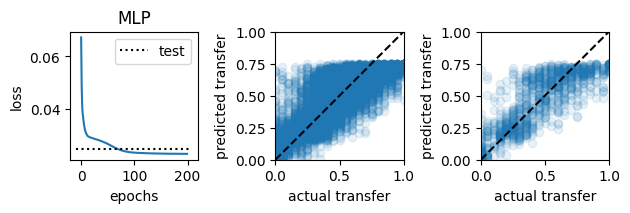

In [80]:
net.eval()

test_outputs = net(torch.nan_to_num(x_test)).squeeze()
train_outputs = net(torch.nan_to_num(x_train)).squeeze()

# test loss
loss_fn = hyperparams['loss_fn']
loss    = loss_fn(test_outputs, y_test).item()

print(loss)

# plot
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)

# plot loss
ax0.plot(list(range(0,hyperparams['num_epochs'])),loss_history)
a = ax0.plot(ax0.get_xlim(),[loss,loss], ':k', label='test')
ax0.set_xlabel('epochs')
ax0.set_ylabel('loss')
ax0.legend(handles=a)

# train set
ax1.scatter(y_train.detach().numpy(), train_outputs.detach().numpy(), alpha=.1)
ax1.plot([0,1],[0,1],'k--')
ax1.set_xlabel('actual transfer')
ax1.set_ylabel('predicted transfer')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# test set
ax2.scatter(y_test.detach().numpy(), test_outputs.detach().numpy(), alpha=.1)
ax2.plot([0,1],[0,1],'k--')
ax2.set_xlabel('actual transfer')
ax2.set_ylabel('predicted transfer')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()
x_left, x_right = ax0.get_xlim()
y_low, y_high   = ax0.get_ylim()
ax0.set_aspect(abs((x_right-x_left)/(y_low-y_high)))
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax0.set_title('MLP')

In [81]:
metrics.r2_score(test_outputs.detach().numpy(), y_test)

0.5028244706042806

0.023851015


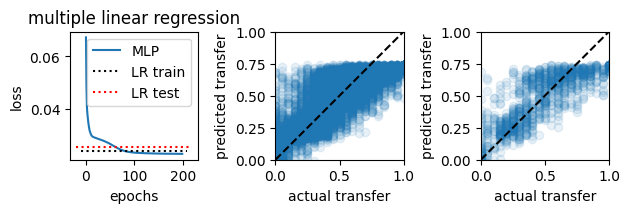

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

mlr = LinearRegression()  
mlr.fit(torch.nan_to_num(x_train), torch.nan_to_num(y_train))

train_outputs_lin = mlr.predict(torch.nan_to_num(x_train))
test_outputs_lin  = mlr.predict(torch.nan_to_num(x_test))

loss_lin_train = metrics.mean_squared_error(y_train, train_outputs_lin)
loss_lin_test = metrics.mean_squared_error(y_test, test_outputs_lin)


# plot
fig, (ax0, ax1, ax2) = plt.subplots(1, 3)

# plot loss
a, = ax0.plot(list(range(0,hyperparams['num_epochs'])),loss_history, label = 'MLP')
b, = ax0.plot(ax0.get_xlim(),[loss_lin_train,loss_lin_train], ':k', label = 'LR train')
c, = ax0.plot(ax0.get_xlim(),[loss_lin_test,loss_lin_test], ':r', label = 'LR test')
ax0.set_xlabel('epochs')
ax0.set_ylabel('loss')
ax0.legend(handles=[a,b,c])


# train set
ax1.scatter(y_train.detach().numpy(), train_outputs_lin, alpha=.1)
ax1.plot([0,1],[0,1],'k--')
ax1.set_xlabel('actual transfer')
ax1.set_ylabel('predicted transfer')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# test set
ax2.scatter(y_test.detach().numpy(), test_outputs_lin, alpha=.1)
ax2.plot([0,1],[0,1],'k--')
ax2.set_xlabel('actual transfer')
ax2.set_ylabel('predicted transfer')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()
x_left, x_right = ax0.get_xlim()
y_low, y_high   = ax0.get_ylim()
ax0.set_aspect(abs((x_right-x_left)/(y_low-y_high)))
ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax0.set_title('multiple linear regression')

print(loss_lin_train)


In [83]:
metrics.r2_score(test_outputs_lin, y_test)

0.48292393708863

In [84]:
from torchviz import make_dot

                       
n_hidden   = 100
n_features = x_train.size(dim=1)

net = Net(n_features,n_hidden)
test_outputs = net(torch.nan_to_num(x_test)).squeeze()

make_dot(test_outputs, params=dict(net.named_parameters()))


TypeError: Net.__init__() missing 1 required positional argument: 'w_scale'